In [1]:
# import duckdb
import pandas as pd
# No need to import duckdb_engine
#  jupysql will auto-detect the driver needed based on the connection string!

# Import jupysql Jupyter extension to create SQL cells
%reload_ext sql
%load_ext sql
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False
%sql duckdb:///:default:

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [3]:
# Plot settings
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['figure.dpi'] = 600
matplotlib.rcParams['font.family'] = ['Inter', 'sans-serif']


In [ ]:
%sql play_by_play << SELECT * FROM read_csv_auto('../archive/csv/play_by_play.csv') ORDER BY game_id, wctimestring LIMIT 40;
play_by_play: pd.DataFrame

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [4]:
%%sql play_by_play_n_games <<
SELECT extract(year from game.game_date) as year, count(*) as n_games
FROM 
(
  SELECT game_id
  FROM read_csv_auto('../archive/csv/play_by_play.csv') as pbp
  GROUP BY game_id
) as pbp
LEFT JOIN read_csv_auto('../archive/csv/game.csv') as game ON pbp.game_id = game.game_id
GROUP BY extract(year from game.game_date)
ORDER BY year
;

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [5]:
play_by_play_n_games: pd.DataFrame


<AxesSubplot:xlabel='year'>

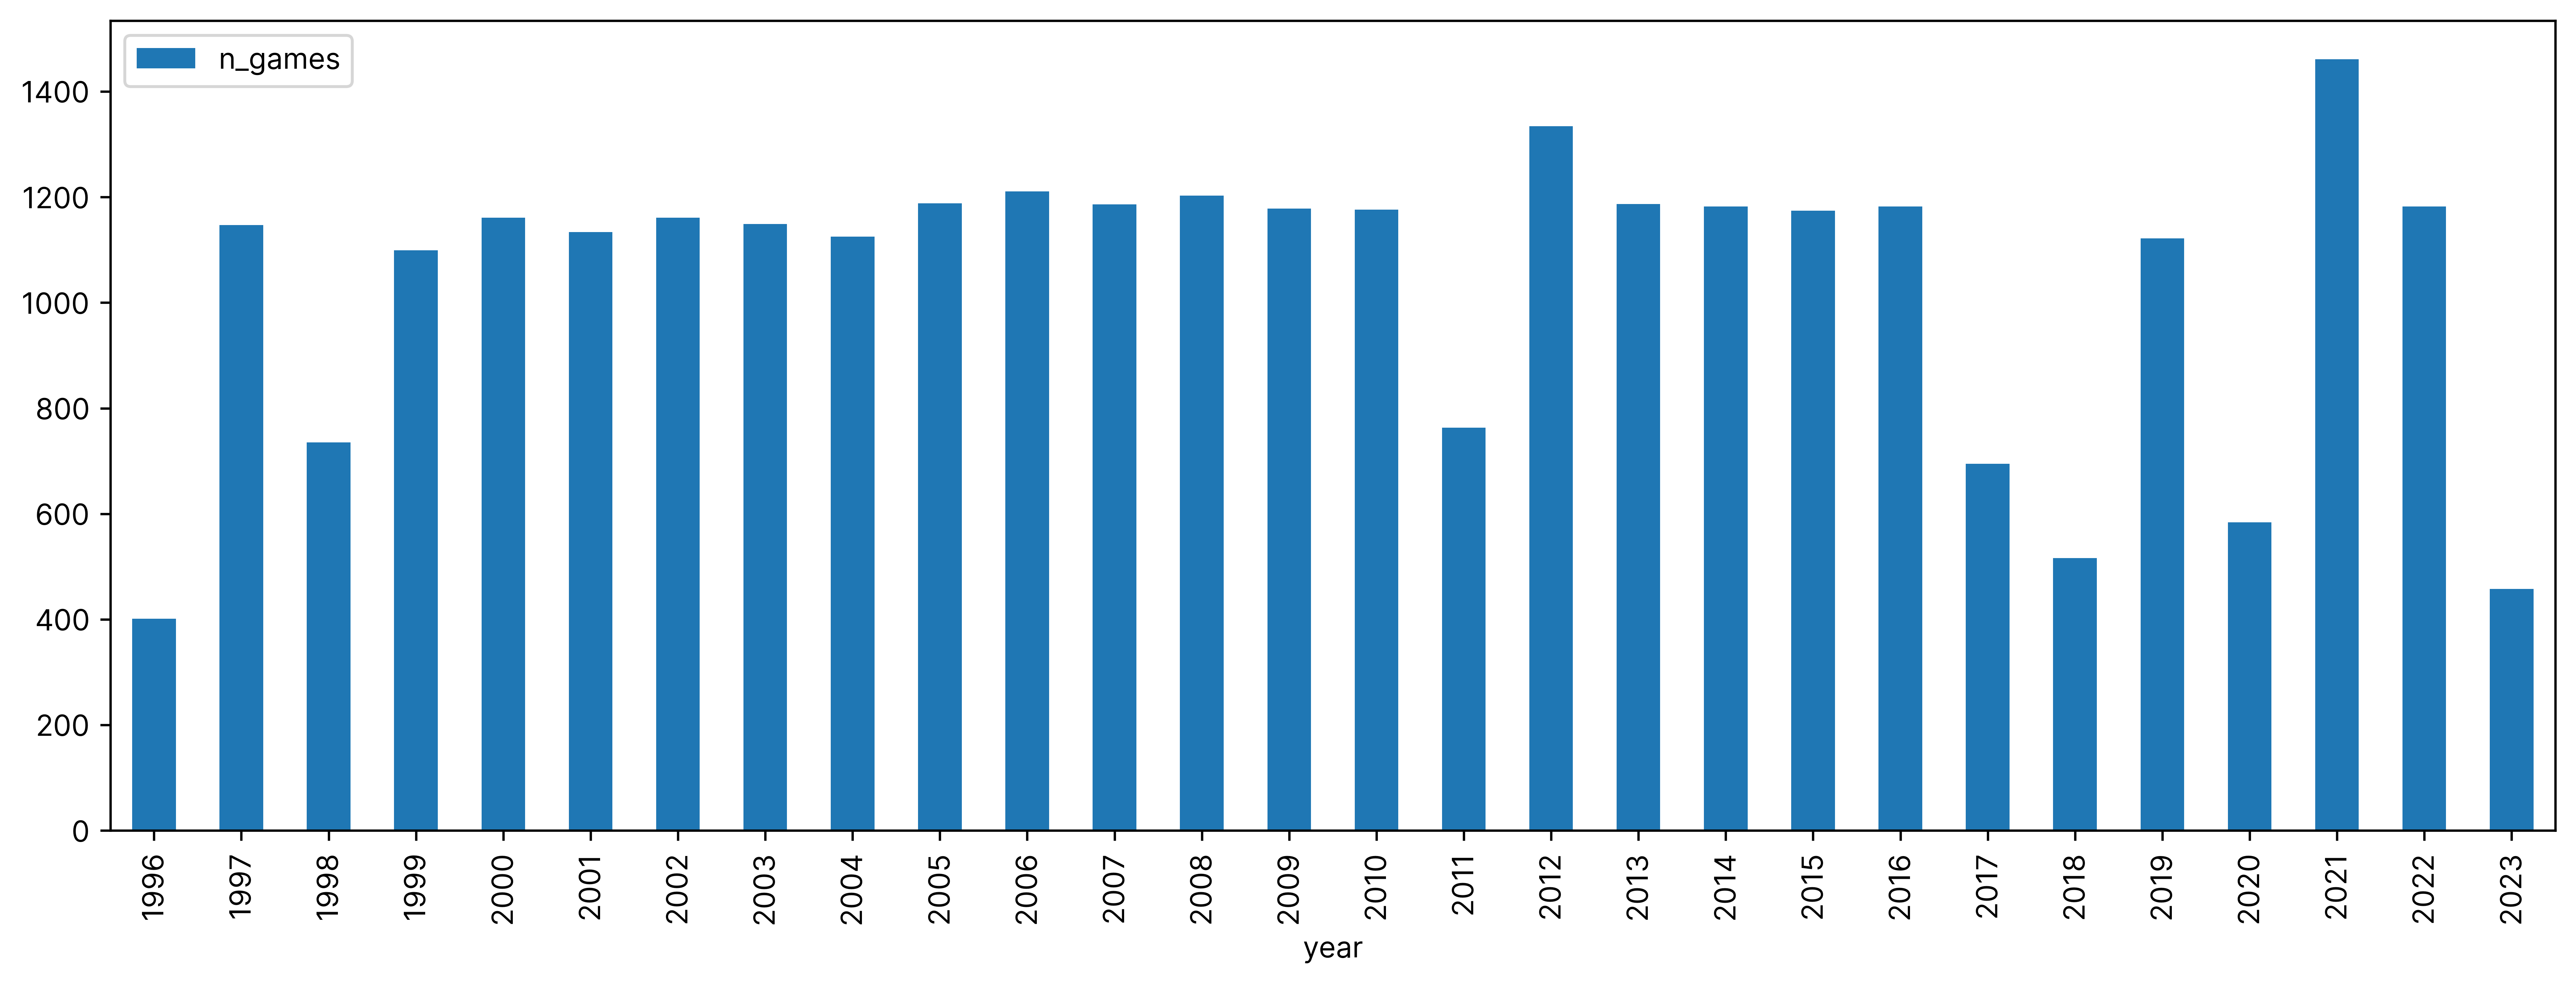

In [6]:
play_by_play_n_games.plot.bar(x='year', y='n_games', figsize=(15, 5))

In [46]:
pd.set_option('display.max_colwidth', 3000)
pd.set_option("display.max_columns", None)
play_by_play.head()

,game_id,eventnum,eventmsgtype,eventmsgactiontype,period,wctimestring,pctimestring,homedescription,neutraldescription,visitordescription,score,scoremargin,person1type,player1_id,player1_name,player1_team_id,player1_team_city,player1_team_nickname,player1_team_abbreviation,person2type,player2_id,player2_name,player2_team_id,player2_team_city,player2_team_nickname,player2_team_abbreviation,person3type,player3_id,player3_name,player3_team_id,player3_team_city,player3_team_nickname,player3_team_abbreviation,video_available_flag
0,0020000001,1,10,0,1,12:13 PM,12:00,Jump Ball Camby vs. Ratliff: Tip to Houston,NaN,NaN,NaN,NaN,4.0,948,Marcus Camby,1.610613e+09,New York,Knicks,NYK,5.0,689,Theo Ratliff,1.610613e+09,Philadelphia,76ers,PHI,4.0,275,Allan Houston,1.610613e+09,New York,Knicks,NYK,0
1,0020000001,0,12,0,1,12:13 PM,12:00,NaN,Start of 1st Period (12:13 PM EST),NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0
2,0020000001,3,4,0,1,12:14 PM,11:40,NaN,NaN,76ers Rebound,NaN,NaN,3.0,1610612755,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0
3,0020000001,4,6,2,1,12:14 PM,11:29,Camby S.FOUL (P1.T1),NaN,NaN,NaN,NaN,4.0,948,Marcus Camby,1.610613e+09,New York,Knicks,NYK,0.0,0,NaN,NaN,NaN,NaN,NaN,1.0,0,NaN,NaN,NaN,NaN,NaN,0
4,0020000001,5,3,11,1,12:14 PM,11:29,NaN,NaN,Ratliff Free Throw 1 of 2 (1 PTS),1 - 0,-1,5.0,689,Theo Ratliff,1.610613e+09,Philadelphia,76ers,PHI,0.0,0,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0


In [10]:
%sql top_schools << SELECT school, count(*) as count FROM read_csv_auto('../archive/csv/common_player_info.csv') AS common_player_info GROUP BY school ORDER BY count DESC LIMIT 40;
top_schools: pd.DataFrame

AttributeError: 'Rectangle' object has no property 'dpi'

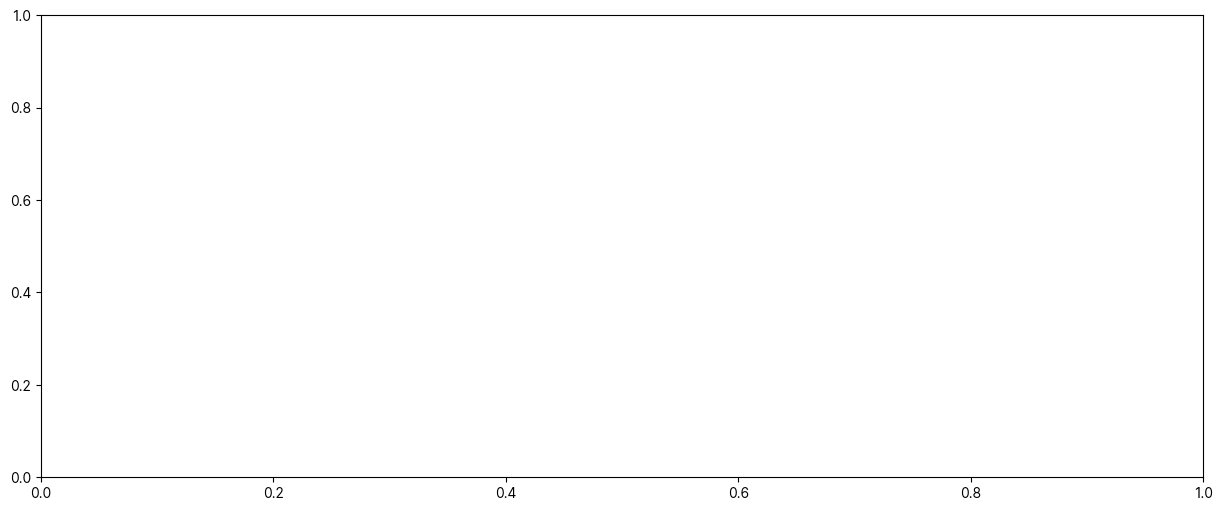

In [21]:
# plot  schools, rotate axis labels

import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = ['Inter', 'sans-serif']

# top_schools.plot.bar(x='school', y='count', rot=0, figsize=(15,6))

# dpi 300

top_schools.plot.bar(x='school', y='count', rot=0, figsize=(15,6), dpi=300)

plt.xticks(rotation = 45, ha="right")
plt.show()
